**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1) Load the dataset and perform splitting into training and validation sets with 70:30 ratio.

> Do we need to normalise data? [If so Does it make any difference?]

2) Implement the K Means algorithm. You need to find the optimal number of clusters using the
    elbow method and silhouette method. 

3) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

4) Experiment with different distance measures[Euclidean distance, Manhattan distance].

5) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.

6) Report the training and the validation accuracy and Compare your trained model with a model trained by the scikit-learn

7) Visualize the dataset to depict the clusters formed. #Prefer T-SNE

8) Implement K-means++, and repeat task 1 to task 7 again.</br>
</br>
</br>
</br>
</br>
**Part 2:**
</br>
In this task, you will perform operations on `[data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`, data.csv is a  latent space representation of  Fashion-MNIST, before doing this task please read about latent space representation.

9) Load the data.csv file and apply Kmeans and Kmeans++, You need to find the optimal number of clusters using the elbow method and silhouette method.

10) Visualize the dataset to depict the clusters formed. # Prefer T-SNE

11) From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?
</br>
</br>
**Note:** If the model takes a lot of time to train you can use MiniBatchKMeans.
 




### GYAN
Silhouette method calculates score for each point. (Refer wikipedia for more info)
after calculating for each point take the average.
Commonly used initialization methods are Forgy and Random Partition.[10] The Forgy method randomly chooses k observations from the dataset and uses these as the initial means. The Random Partition method first randomly assigns a cluster to each observation and then proceeds to the update step, thus computing the initial mean to be the centroid of the cluster's randomly assigned points. The Forgy method tends to spread the initial means out, while Random Partition places all of them close to the center of the data set. The Random Partition method is generally preferable for algorithms such as the k-harmonic means and fuzzy k-means. For expectation maximization and standard k-means algorithms, the Forgy method of initialization is preferable..

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import cm

In [149]:
#implement elbow method from scratch
def elbow(X, labels, Centroids):
    k = Centroids.shape[0]
    summ = 0
    for i in range(k):
        X_new = X[labels == i]
        if X_new.shape[0] == 0:
            continue
        cent = Centroids[i][np.newaxis, :]
        dist_mat = -2 * np.dot(cent, X_new.T) + np.sum(X_new**2, axis=1) + np.sum(cent**2, axis=1)[:, np.newaxis]
        summ += np.sum(dist_mat, axis=1)
    return summ

In [199]:
#implement silhouette method from scratch
def silhouette(X, labels, Centroids):
    k = Centroids.shape[0]
    within_cluster = np.zeros(X.shape[0])
    for i in range(k):
        mask = labels == i
        X_new = X[mask]
        if X_new.shape[0] <= 1:
            continue
        # calculate distance b/w every pair of points in a cluster
        dist_mat = -2*np.dot(X_new, X_new.T) + np.sum(X_new**2, axis=1) + np.sum(X_new**2, axis=1)[:, np.newaxis]
        within_cluster[mask] = np.sum(dist_mat, axis=1)/(X_new.shape[0] - 1) # we store the mean distance
    
    inter_cluster = np.array([1e9] * X.shape[0])
    for i in range(k):
        for j in range(k):
            if i == j:
                continue
            maski = labels == i
            maskj = labels == j
            # we calculate distance from i to j (for i)
            Xi = X[maski]
            Xj = X[maskj]
            if Xj.shape[0] == 0 or Xi.shape[0] == 0:
                continue
            dist_mat = -2*np.dot(Xi, Xj.T) + np.sum(Xj**2, axis=1) + np.sum(Xi**2, axis=1)[:, np.newaxis]
            dist = np.sum(dist_mat, axis=1)/(Xj.shape[0])
            inter_cluster[maski] = np.min([inter_cluster[maski], dist], axis=0)
    score = (inter_cluster - within_cluster)/np.max([inter_cluster, within_cluster], axis=0)
    return np.sum(score)/score.shape[0]

In [128]:
#implement Kmeans from scratch
class Kmeans:
    # initialise k clusters (Random or Forgy)
    # write the iterative method for finding next clusters
    def __init__(self, X, k, init_method, dist_measure, iterations, centro=None):
        self.init_method = init_method
        self.dist_measure = dist_measure
        self.iterations = iterations
        self.k = k
        self.X = X
        self.labels = np.zeros(X.shape[0])
        self.initialised = False
        if centro is not None:
            self.centroids = centro
            self.initialised = True
            self.plot_data()
        else:
            self.centroids = np.zeros((k, X.shape[1]))
    
    def give_centroids(self):
        return self.centroids
    
    def give_labels(self):
        return self.labels
    
    def initialise(self):
        if self.init_method == 'Forgy':
            points = dict()
            cnt = 0
            while cnt < self.k:
                p = np.random.randint(0, X.shape[0]-1)
                if p not in points.keys():
                    self.centroids[cnt] = X[p]
                    cnt += 1
                    points[p] = 1
        elif self.init_method == 'Random':
            clusters = np.random.randint(self.k, size=self.X.shape[0])
            for i in range(self.k):
                clusters[i] = i # making sure that each centroid gets at least one point
            for i in range(self.k):
                mask = clusters == i
                x_new = self.X[mask]
                self.centroids[i] = x_new.mean(axis=0)
        else:
            raise NotImplementedError('Wrong initialisation method')
        self.plot_data()
    
    def dist_matrix_manhattan(self):
        num_train = self.X.shape[0]
        dist_mat = np.zeros((num_train, self.k))
        for i in range(num_train):
            dist_mat[i, :] = np.sum(np.abs(self.centroids - self.X[i, :]), axis=1)
        return dist_mat
        
    def dist_matrix(self, X):
        dist_mat = -2 * np.dot(self.X, X.T) + np.sum(X**2, axis=1) + np.sum(self.X**2, axis=1)[:, np.newaxis]
        return dist_mat
    
    def realign(self):
        if self.dist_measure == 'euclidean':
            dist_mat = self.dist_matrix_manhattan()
        elif self.dist_measure == 'manhattan':
            dist_mat = self.dist_matrix(self.centroids)
        else:
            raise NotImplementedError('Wrong distance measure')
        clusters = np.argmin(dist_mat, axis=1)
        for i in range(self.k):
            mask = clusters == i
            x_new = self.X[mask]
            if x_new.shape[0] > 0: # It might happen that no point is assigned to a particular centroid (Quite Dangerous)
                self.centroids[i] = x_new.mean(axis=0)
        self.labels = clusters
        self.plot_data()
        
    def plot_data(self):
        if self.X.shape[1] == 2:
            colors = cm.rainbow(np.linspace(0.0, 1.0, self.k))
            for this_y, color in zip(range(self.k), colors):
                this_X = self.X[self.labels == this_y]
                plt.scatter(this_X[:, 0], this_X[:, 1],
                            c=color[np.newaxis, :],
                            alpha=0.5, edgecolor='k',
                            label="Class %s" % this_y)
            plt.legend(loc="best")
            plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker="s", c='black')
            plt.title("Data")
            plt.show()
    
    def train(self):
        if not self.initialised:
            self.initialise()
        for _ in range(self.iterations):
            self.realign()
            

## Dummy Data

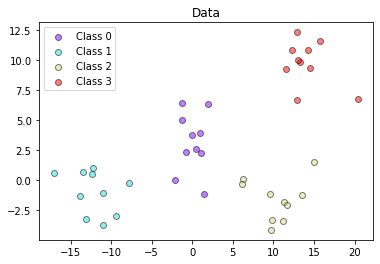

In [203]:
centers = [[0, 3], [-12, -1], [10, -2], [13, 9]] 
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 40, 
                            centers = centers, 
                            cluster_std = 2.2)
y_unique = np.unique(labels_true)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[labels_true == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

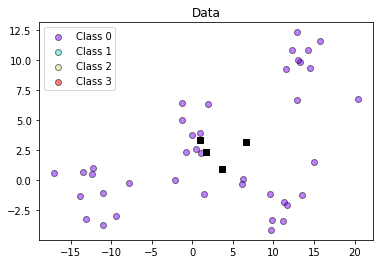

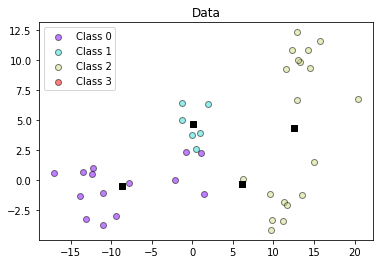

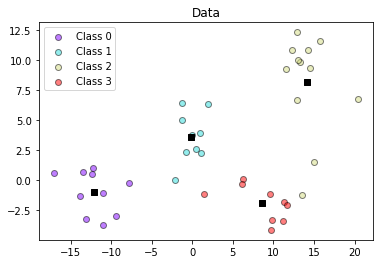

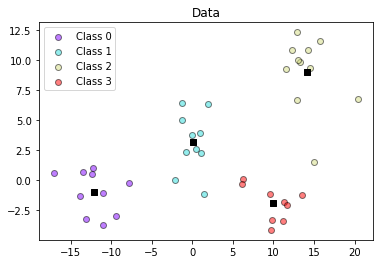

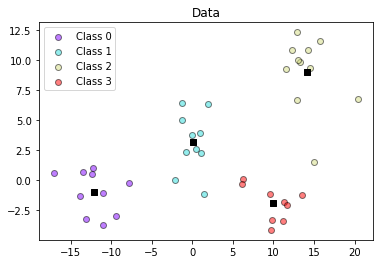

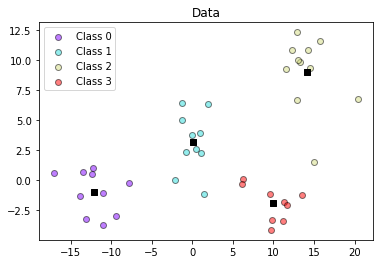

0.8203117310265137

In [204]:
km = Kmeans(X, 4, 'Random', 'euclidean', 5)
km.train()
centroids = km.give_centroids()
labels = km.give_labels()
silhouette(X, labels, centroids)

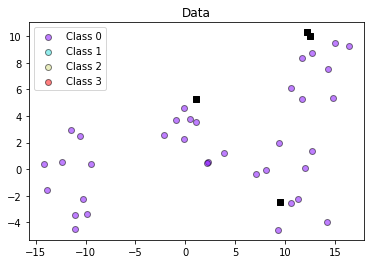

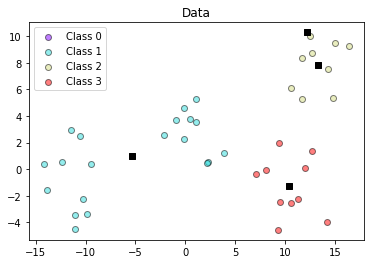

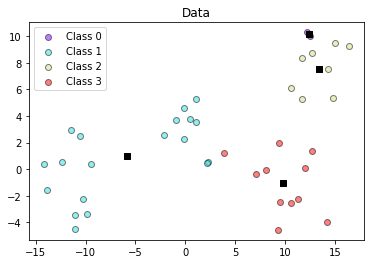

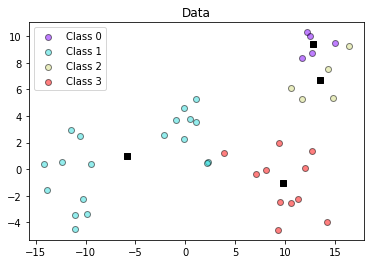

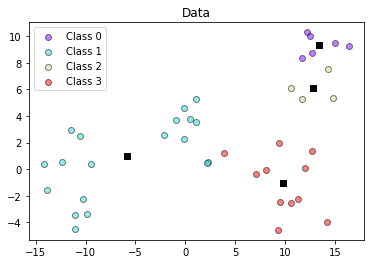

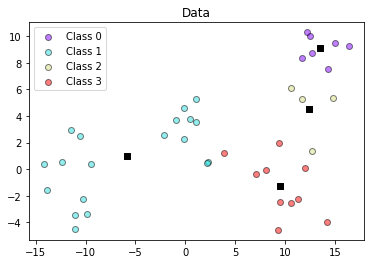

In [94]:
km = Kmeans(X, 4, 'Forgy', 'euclidean', 5)
km.train()

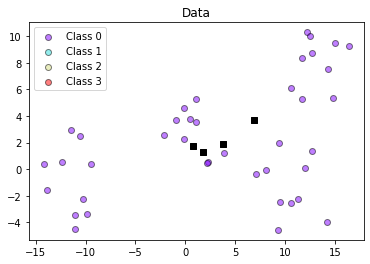

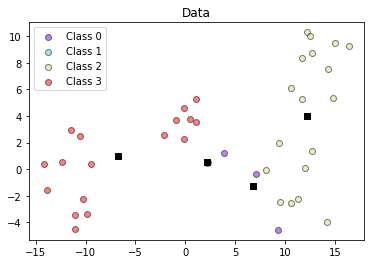

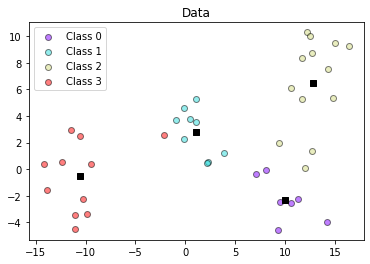

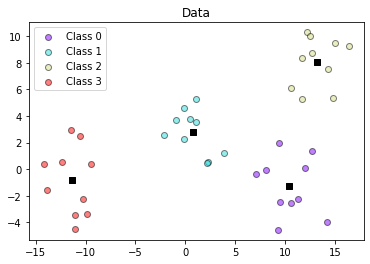

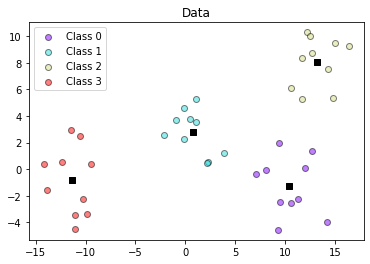

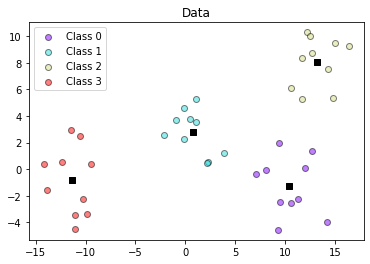

In [99]:
km = Kmeans(X, 4, 'Random', 'manhattan', 5)
km.train()

### Interesting Observation
1. It might happen that no point gets assigned to a centroid, in that case we will not change it position.
2. In the upcoming iterations some points can be assigned to it as we see in the 2nd and 3rd graph below.

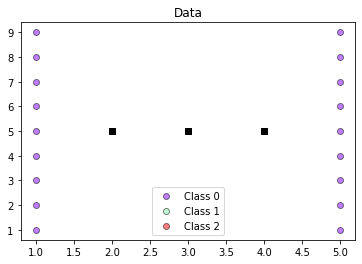

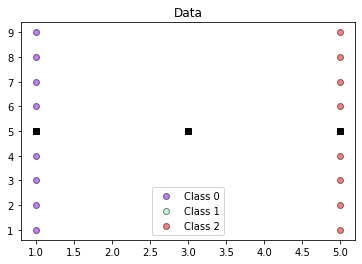

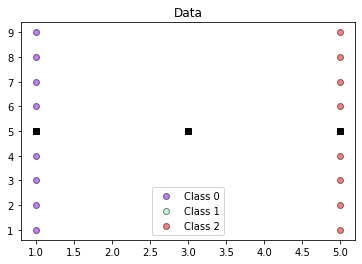

0.5120134439604426

In [201]:
X = [[1, i] for i in range(1, 10)] + [[5, i] for i in range(1, 10)]
X = np.array(X)
centro = np.array([[2, 5], [3, 5], [4, 5]])
km = Kmeans(X, 3, 'Random', 'euclidean', 2, centro=centro)
km.train()
centroids = km.give_centroids()
labels = km.give_labels()
silhouette(X, labels, centroids)

In [190]:
#implement Kmeans++ from scratch
class Kmeansplusplus:

    def __init__(self, X, k, dist_measure, iterations):
        self.dist_measure = dist_measure
        self.iterations = iterations
        self.k = k
        self.X = X
        self.centroids = np.zeros((k, X.shape[1]))
        self.labels = np.zeros(X.shape[0])
        self.dist = np.array([1e9]*X.shape[0])
    
    @staticmethod
    def choice(p):
        '''
        Generates a random sample from [0, len(p)),where p[i] is the probability associated with i. 
        '''
        random = np.random.random()
        cdf = 0.0
        for idx in range(p.shape[0]):
            cdf = cdf + p[idx]
            if cdf > random:
                return idx
        raise ValueError("probabilities don't add up to 1.0")
        
    def update(self, centroids):
        dist_mat = -2*np.dot(centroids, self.X.T) + np.sum(self.X**2, axis=1) + np.sum(centroids**2, axis=1)[:, np.newaxis]
        dist_mat = np.min(dist_mat, axis=0)
        self.dist = np.min([dist_mat, self.dist], axis=0) # take the point-wise min and update the dist array
    
    def initialise(self):
        ind = np.random.randint(0, self.X.shape[0]) # get the first centroid
        self.centroids[0] = X[ind]
        for i in range(1, self.k):
            self.update(self.centroids[:i]) # update the distances
            probability = self.dist/self.dist.sum()
            ind = self.choice(probability)
            self.centroids[i] = X[ind]
        self.plot_data()
            
    def give_centroids(self):
        return self.centroids
    
    def give_labels(self):
        return self.labels
    
    def dist_matrix_manhattan(self):
        num_train = self.X.shape[0]
        dist_mat = np.zeros((num_train, self.k))
        for i in range(num_train):
            dist_mat[i, :] = np.sum(np.abs(self.centroids - self.X[i, :]), axis=1)
        return dist_mat
        
    def dist_matrix(self, X):
        dist_mat = -2*np.dot(self.X, X.T) + np.sum(X**2, axis=1) + np.sum(self.X**2, axis=1)[:, np.newaxis]
        return dist_mat
    
    def realign(self):
        if self.dist_measure == 'euclidean':
            dist_mat = self.dist_matrix_manhattan()
        elif self.dist_measure == 'manhattan':
            dist_mat = self.dist_matrix(self.centroids)
        else:
            raise NotImplementedError('Wrong distance measure')
        clusters = np.argmin(dist_mat, axis=1)
        for i in range(self.k):
            mask = clusters == i
            x_new = self.X[mask]
            if x_new.shape[0] > 0: # It might happen that no point is assigned to a particular centroid (Quite Dangerous)
                self.centroids[i] = x_new.mean(axis=0)
        self.labels = clusters
        self.plot_data()
        
    def plot_data(self):
        if self.X.shape[1] == 2:
            colors = cm.rainbow(np.linspace(0.0, 1.0, self.k))
            for this_y, color in zip(range(self.k), colors):
                this_X = self.X[self.labels == this_y]
                plt.scatter(this_X[:, 0], this_X[:, 1],
                            c=color[np.newaxis, :],
                            alpha=0.5, edgecolor='k',
                            label="Class %s" % this_y)
            plt.legend(loc="best")
            plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker="s", c='black')
            plt.title("Data")
            plt.show()
    
    def train(self):
        self.initialise()
        for _ in range(self.iterations):
            self.realign()
 

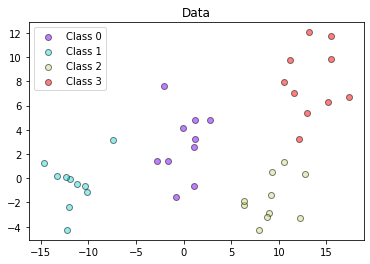

In [172]:
centers = [[0, 3], [-12, -1], [10, -2], [13, 9]] 
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples = 40, 
                            centers = centers, 
                            cluster_std = 2.2)
y_unique = np.unique(labels_true)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[labels_true == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")
plt.show()

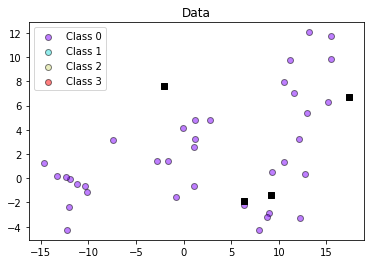

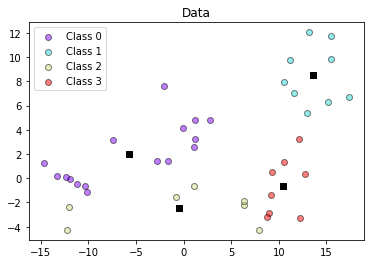

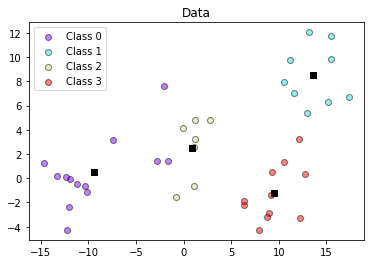

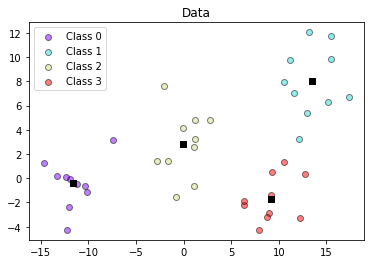

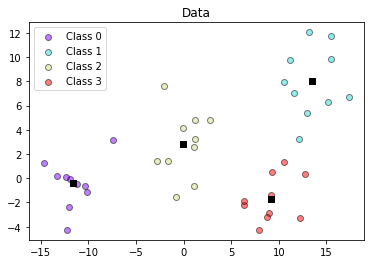

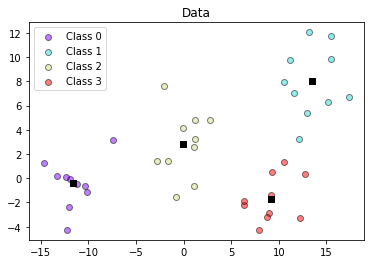

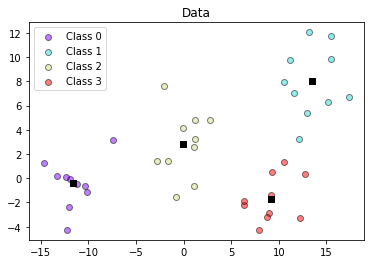

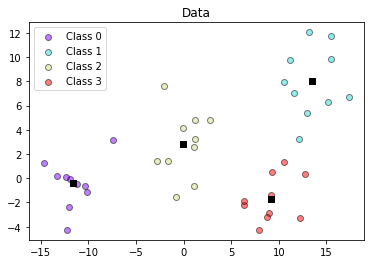

In [192]:
km = Kmeansplusplus(X, 4, 'euclidean', 7)
km.train()

In [9]:
train = pd.read_csv('fashion-mnist_train.csv')

In [12]:
y_train = train['label']

In [21]:
x_train = train.drop(['label'], axis=1)

In [22]:
x_train = x_train.to_numpy()

In [26]:
print(x_train.shape)
x_train = x_train.reshape(60000, 28, 28)

(60000, 784)


In [27]:
print(x_train.shape)

(60000, 28, 28)


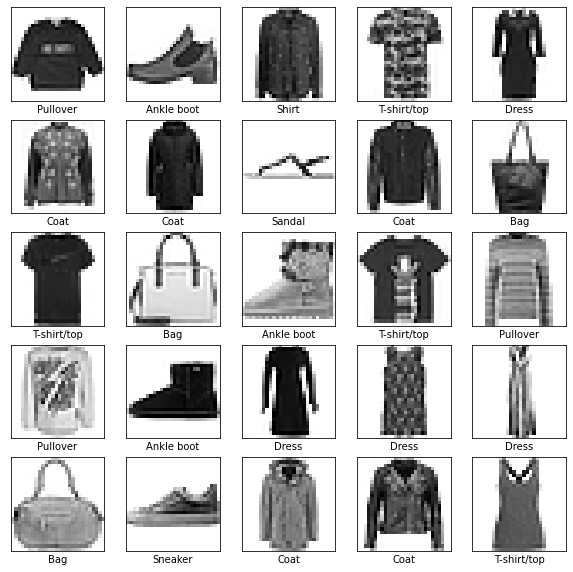

In [29]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()